# Windows 10 Coin

train:  (row: 1,347,190, columns: 1,085)
test:   (row:   374,136, columns: 1,084)

y value: if HasClicked == True, app 1.8%

How to run
1. Put the train and test files in ..\input
2. Put the script file in ..\script
3. In Jupyter Notebook, run all and get submission file in the same script folder

In [66]:
# Timer and file info
import math
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc # We're gonna be clearing memory a lot
import matplotlib.pyplot as plt
import seaborn as sns
import random
import lightgbm as lgb
#from ml_metrics import mapk
import hashlib
from datetime import datetime
import re
import csv
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import matthews_corrcoef, f1_score, classification_report, confusion_matrix, precision_score, recall_score
%matplotlib inline

# Timer
class Timer:
    def __init__(self, text=None):
        self.text = text
        
    def __enter__(self):
        self.cpu = time.clock()
        self.time = time.time()
        if self.text:
            print("{}...".format(self.text))
            print(datetime.now())
        return self

    def __exit__(self, *args):
        self.cpu = time.clock() - self.cpu
        self.time = time.time() - self.time
        if self.text:
            print("%s: cpu %0.2f, time %0.2f\n" % (self.text, self.cpu, self.time))

# Split to train and holdout sets with counts
def sample_train_holdout(_df, sample_count, holdout_count):   
    random.seed(7)
    sample_RowNumber = random.sample(list(_df['RowNumber']), (sample_count + holdout_count))
    train_RowNumber = random.sample(sample_RowNumber, sample_count)
    holdout_RowNumber = list(set(sample_RowNumber) - set(train_RowNumber))
    holdout = _df[_df['RowNumber'].isin(holdout_RowNumber)].copy()
    _df = _df[_df['RowNumber'].isin(train_RowNumber)]
    return _df, holdout 

# Sampling for train and holdout with imbalanced binary label
def trainHoldoutSampling(_df, _id, _label, _seed=7, t_tr=0.5, t_ho=0.5, f_tr=0.05, f_ho=0.5):
    random.seed(_seed)
    
    positive_id = list(_df[_df[_label]==True][_id].values)
    negative_id = list(_df[_df[_label]==False][_id].values)
    
    train_positive_id = random.sample(positive_id, int(len(positive_id) * t_tr))
    holdout_positive_id = random.sample(list(set(positive_id)-set(train_positive_id)), int(len(positive_id) * t_ho)) 
    train_negative_id = random.sample(negative_id, int(len(negative_id) * f_tr))
    holdout_negative_id = random.sample(list(set(negative_id)-set(train_negative_id)), int(len(negative_id) * f_ho))
    
    train_id = list(set(train_positive_id)|set(train_negative_id))
    holdout_id = list(set(holdout_positive_id)|set(holdout_negative_id))
    
    print('train count: {}, train positive count: {}'.format(len(train_id),len(train_positive_id)))
    print('holdout count: {}, holdout positive count: {}'.format(len(holdout_id),len(holdout_positive_id)))
    
    return _df[_df[_id].isin(train_id)], _df[_df[_id].isin(holdout_id)]

def datetime_features2(_df, _col):
    _format='%m/%d/%Y %I:%M:%S %p'
    _df[_col] = _df[_col].apply(lambda x: datetime.strptime(x, _format))
    
    colYear = _col+'Year'
    colMonth = _col+'Month'
    colDay = _col+'Day'
    colHour = _col+'Hour'
    #colYearMonthDay = _col+'YearMonthDay'
    #colYearMonthDayHour = _col+'YearMonthDayHour' 
    
    _df[colYear] = _df[_col].apply(lambda x: x.year)
    _df[colMonth] = _df[_col].apply(lambda x: x.month)
    _df[colDay] = _df[_col].apply(lambda x: x.day)
    _df[colHour] = _df[_col].apply(lambda x: x.hour)
    
    #ymd = [colYear, colMonth, colDay]
    #ymdh = [colYear, colMonth, colDay, colHour]
    
    #_df[colYearMonthDay] = _df[ymd].apply(lambda x: '_'.join(str(x)), axis=1)
    #_df[colYearMonthDayHour] = _df[ymdh].apply(lambda x: '_'.join(str(x)), axis=1)

    return _df
    
# Change date column datetime type and add date time features
def datetime_features(_df, _col, isDelete = False):
    # 1. For years greater than 2017, create year folder with regex and change year to 2017 in datetime column
    # find and return 4 digit number (1st finding) in dataframe string columns
    year_col = _col + 'Year'
    _df[year_col] = _df[_col].apply(lambda x: int(re.findall(r"\D(\d{4})\D", " "+ str(x) +" ")[0]))
    years = sorted(list(_df[year_col].unique()))
    yearsGreaterThan2017 = sorted(i for i in years if i > 2017)

    # Two ways for strange year data (1) change it to 2017 temporarily (2) remove from data; we will go with (1)
    # because we cannot remove test rows anyway
    if isDelete:
        _df = _df[~_df[year_col].isin(yearsGreaterThan2017)]
    else:
        for i in yearsGreaterThan2017:
            print("replace ", i, " to 2017 for conversion")
            _df.loc[_df[year_col] == i, _col] = _df[_df[year_col] == i][_col].values[0].replace(str(i), "2017")
    
    # How to remove strange year rows
    # train = train[~train['year'].isin(yearsGreaterThan2017)]

    # 2. Convert string to datetime
    _df[_col] = pd.to_datetime(_df[_col])
    print(_col, "column conversion to datetime type is done")
    
    # 3. Add more date time features
    month_col = _col + 'Month'
    week_col = _col + 'Week'
    weekday_col = _col + 'Weekday'
    day_col = _col + 'Day'
    hour_col = _col + 'Hour'
    #year_month_day_col = _col + 'YearMonthDay'
    #year_month_day_hour_col = _col + 'YearMonthDayHour'
    
    _df[month_col] = pd.DatetimeIndex(_df[_col]).month
    _df[week_col] = pd.DatetimeIndex(_df[_col]).week
    _df[weekday_col] = pd.DatetimeIndex(_df[_col]).weekday
    _df[day_col] = pd.DatetimeIndex(_df[_col]).day
    _df[hour_col] = pd.DatetimeIndex(_df[_col]).hour
    #_df[year_month_day_col] = _df[[year_col, month_col, day_col]].apply(lambda x: ''.join(str(x)), axis=1)
    #_df[year_month_day_hour_col] = _df[[year_col, month_col, day_col, hour_col]].apply(lambda x: ''.join(str(x)), axis=1)
    print("year, month, week, weekday, day, hour features are added")
    
    return _df

# Delete rows with list condition for dataframe
def delRows(_df, _col, _list):
    _df = _df[~_df[_col].isin(_list)]
    return _df

import re

# Create new column using regex pattern for strings for dataframe
def addFeatureRegex(_df, _col, _newCol):
    _df[_newCol] = _df[_col].apply(lambda x: int(re.findall(r"\D(\d{4})\D", " "+ str(x) +" ")[0]))
    return _df

# Convert string to datetime type
def stringToDatetime(_df, _col):
    _df[_col] = _df[_col].astype('datetime64[ns]')
    return _df

# Add features from datetime
def addDatetimeFeatures(_df, _col):
    _df[_col + 'Year'] = pd.DatetimeIndex(_df[_col]).year
    _df[_col + 'Month'] = pd.DatetimeIndex(_df[_col]).month
    _df[_col + 'Week'] = pd.DatetimeIndex(_df[_col]).week
    _df[_col + 'Weekday'] = pd.DatetimeIndex(_df[_col]).weekday
    _df[_col + 'Day'] = pd.DatetimeIndex(_df[_col]).day
    _df[_col + 'Hour'] = pd.DatetimeIndex(_df[_col]).hour
    return _df

# Get categorical column names
def categoricalColumns(_df):
    cat_columns = _df.select_dtypes(['object']).columns
    print("Categorical column count:", len(cat_columns))
    print("First 5 values:", cat_columns[:5])
    return cat_columns

# Get column names starting with
def columnsStartingWith(_df, _str):
    sorted_list = sorted(i for i in list(_df) if i.startswith(_str))
    print("Column count:", len(sorted_list))
    print("First 5 values:", sorted_list[:5])    
    return sorted_list

# Get column names ending with
def columnsEndingWith(_df, _str):
    sorted_list = sorted(i for i in list(_df) if i.endswith(_str))
    print("Column count:", len(sorted_list))
    print("First 5 values:", sorted_list[:5])    
    return sorted_list

# Get constant columns
def constantColumns(_df):
    constant_list = []
    cols = list(_df) # same as _df.columns.values
    for col in cols:
        if len(_df[col].unique()) == 1:
            constant_list.append(col)
    print("Constant column count:", len(constant_list))
    print("First 5 values:", constant_list[:5])  
    return constant_list

# Add null columns
def makeNullColumns(_df, _cols):
    null_df = _df[_cols].isnull()
    null_df.columns = null_df.columns + 'Null'
    _df = pd.concat([_df, null_df], axis=1)
    return _df

# Union
def union(a, b):
    return list(set(a)|set(b))

def unique(a):
    return list(set(a))

# undersampling - sample rate 0.8 for 80% samling using isUndersampled column 
def underSampling(_df, _sample_rate):
    _df['isUnderSampled'] = 1
    _rand_num = 1/(1-_sample_rate)
    underSample = np.random.randint(_rand_num, size=len(_df[_df['HasClicked'] == 0]))
    _df.loc[_df['HasClicked'] == 0, 'isUnderSampled'] = underSample>0
    return _df

# Add column with value count
def valueCountColumn(_df, _col):
    _dict = dict([(i, a) for i, a in zip(_df[_col].value_counts().index, _df[_col].value_counts().values)])
    _df[_col+'ValueCount'] = _df[_col].apply(lambda x: _dict[x])
    return _df

# Add column with bool values to check if keyword is contained or not
def containColumn(_df, _col, _str):
    _df[_col+'Cotains'+_str] = _df[_col].str.contains(_str)
    return _df

# Feature engineering
def feature_engineering(_df):
    print("shape:", _df.shape)
    print("Add datetime features...")
    datetime_columns = ['BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime']
    for col in datetime_columns:
        print(col)
        if _df[col].isnull().sum() > 0:
            _df[col] = _df[col].fillna('1/1/2017 11:11:11 AM')
        _df = datetime_features2(_df, col)

    print("shape:", _df.shape)

    gc.collect()
    
    # Null count
    print("Missing value count...")
    _df['CntNs'] = _df.isnull().sum(axis=1) 

    cols = ['AppCategoryNMinus1', 'AppCategoryNMinus2', 'AppCategoryNMinus3', 'AppCategoryNMinus4', 'AppCategoryNMinus5',
           'AppCategoryNMinus6', 'AppCategoryNMinus7', 'AppCategoryNMinus8']
    _df['AppCatCntNs'] = _df[cols].isnull().sum(axis=1)

    #_df[cols] = _df[cols].fillna("NA")
    #for col in cols:
    #    print(col)
    #    _df[col+'HighLevel'] = _df[col].apply(lambda x: str(x).split(':')[0])
   
    # Game segment parse with '.'
    # to-do: 2nd and 3rd parsed values to add as features later, some exception handling is needed
    print("Gamer segment parsing...")
    _df['GamerSegment1'] = _df['GamerSegment'].apply(lambda x: str(x).split('.')[0] if str(x).split('.') else 'Unknown')
    
    # Check creativeName contains keyword or not - Week 7 is removed because space is not addressed in lightgbm v2 model
    keywords = ['SL', 'TS', 'Week7', 'Meet', 'Skype', 'Battery', 'Switch', 'Performance', 'Security', 'Surge']
    for keyword in keywords:
        _df = containColumn(_df, 'creativeName', keyword)
    #_df['week7'] = _df['Week7'].values + _df['Week 7'].values
    #_df.drop(['Week7', 'Week 7'], axis = 1, inplace = True)
    
    # Convert categorical columns to numeric
    print("Convert categorical columns to numeric...")
    cat_columns = _df.select_dtypes(['object']).columns
    for cat_column in cat_columns:
        print(cat_column)
        if cat_column == 'creativeName':
            _df['creativeNameTest'] = _df['creativeName'].values
        #_df[cat_column] = _df[cat_column].apply(lambda x: abs(hash(x)) )
        _df[cat_column] = _df[cat_column].apply(lambda x: int(hashlib.sha1(str(x).encode('utf-8')).hexdigest(), 16) % (10 ** 16) )
    gc.collect()
    
    # Replace missing values with -1
    print("Replace missing values with -1")
    _df = _df.fillna(-1)
    
    # Value count
    print("Value count...")
    cols = ['UniqueUserDeviceKey', 'CampaignId']
    for col in cols:
        print(col)
        _df = valueCountColumn(_df, col)
        
    return _df

# Get best threshold value for F1 score
def f1_best_threshold(_actual, _pred):
    thresholds = np.linspace(0.01, 0.5, 1000)

    fc = np.array([f1_score(_actual, _pred>thr) for thr in thresholds])
    plt.plot(thresholds, fc)
    best_threshold = thresholds[fc.argmax()]
    print('f1 score:', fc.max())
    print('best threshold:', best_threshold)
    print('TF pred mean:', (_pred>best_threshold).mean())
    
    return best_threshold

In [67]:
with Timer("Read train data..."):
    train = pd.read_csv('CoinMlCompetitionSoftlandingTrainWithHeader.tsv', sep='\t') # (1347190, 1085)
    print(train.shape)
    
    test_header = train.columns[0:1084]

Read train data......
2017-04-07 05:56:46.235156


C:\Users\ryutek\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,8,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1347190, 1085)
Read train data...: cpu 209.50, time 209.52



In [68]:
df_header = pd.DataFrame(test_header)
df_header.to_csv('test_header.csv', index = False)

In [69]:
with Timer("Decide feature columns..."):
    # Reduce size by removing most of days and time features
    features = train.columns
    
    print("features without time_ and days_ columns")
    time_columns = columnsStartingWith(train, 'Time_')
    days_columns = columnsStartingWith(train, 'Days_')
    features = list(set(features) - set(time_columns))
    features = list(set(features) - set(days_columns))
    
    # Add important time features from feature importance and some validation
    imp_time_features = ['Time_Accessibility', 'Time_Browser', 'Time_Communications', 'Time_Content', 'Time_DevTools', 
                     'Time_Games', 'Time_Malware', 'Time_Media', 'Time_PersonalProductivity', 'Time_Readers', 
                     'Time_Search', 'Time_Social', 'Time_StudentAndLearning', 'Time_ModernApps', 
                     'Time_Games_Core', 'Time_Games_Casual', 'Time_windows_immersivecontrolpanel',
                     'Time_msascui_exe', 'Time_chrome_exe', 'Time_microsoft_windows_cortana', 'Time_lockapphost_exe']
    features = list(set(features) | set(imp_time_features))
    
    train = train[features]
    print(train.shape)
    
    df_features = pd.DataFrame(features)
    df_features.to_csv('initial_features.csv', index = False)
    
    #with open('feature_list', 'wb') as fp:
    #    pickle.dump(features, fp)

Decide feature columns......
2017-04-07 06:00:15.816642
features without time_ and days_ columns
Column count: 517
First 5 values: ['Time_0c72c7cd_217379cb4ae6f', 'Time_0c72c7cd_beta', 'Time_123freesolitaire_exe', 'Time_1cv8_exe', 'Time_2345explorer_exe']
Column count: 517
First 5 values: ['Days_0c72c7cd_217379cb4ae6f', 'Days_0c72c7cd_beta', 'Days_123freesolitaire_exe', 'Days_1cv8_exe', 'Days_2345explorer_exe']
(1347190, 72)
Decide feature columns...: cpu 0.68, time 0.67



In [70]:
# Train feature engineering
with Timer("Train feature engineering..."):
    #train = feature_engineering(train, isDeleteOddDateRows=True)
    train = feature_engineering(train)
    
    train_y = train['HasClicked'].values
    print("train y mean:", train_y.mean())

Train feature engineering......
2017-04-07 06:00:16.504007
shape: (1347190, 72)
Add datetime features...
BubbleShownTime
FirstUpdatedDate
OSOOBEDateTime
shape: (1347190, 84)
Missing value count...
Gamer segment parsing...
Convert categorical columns to numeric...
GamerSegment
BubbleShownTime
AppCategoryNMinus1
IsVirtualDevice
DefaultInternetBrowser
AppCategoryNMinus8
DisplayLanguage
AppCategoryNMinus7
AppCategoryNMinus3
GamerPCClassification
AppCategoryNMinus2
AppCategoryNMinus4
IsAlwaysOnAlwaysConnectedCapable
OSOOBEDateTime
AppCategoryNMinus5
IsDomainJoined
CampaignId
creativeName
ISOCountryShortName
AppCategoryNMinus6
DeviceTimezone
GamerSegment1
creativeNameCotainsSL
creativeNameCotainsTS
creativeNameCotainsWeek7
creativeNameCotainsMeet
creativeNameCotainsSkype
creativeNameCotainsBattery
creativeNameCotainsSwitch
creativeNameCotainsPerformance
creativeNameCotainsSecurity
creativeNameCotainsSurge
Replace missing values with -1
Value count...
UniqueUserDeviceKey
CampaignId
train y me

In [71]:
with Timer("Read test and feature engineering..."):
    # Read tsv file
    test = pd.read_csv('CoinMlCompetitionSoftlandingEvaluateNoLabel.tsv', sep='\t', header = None)
    
    # Add header because test does not header
    test.columns = test_header
    
    # Reduce test size by leaving train features only
    test = test[list(set(features) - set(['HasClicked']))]
    
    # Feature engineering - should not delete odd date rows
    #test = feature_engineering(test, isDeleteOddDateRows=False)
    test = feature_engineering(test)
    
    print(test.shape)

Read test and feature engineering......
2017-04-07 06:04:15.831781


C:\Users\ryutek\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


shape: (374137, 71)
Add datetime features...
BubbleShownTime
FirstUpdatedDate
OSOOBEDateTime
shape: (374137, 83)
Missing value count...
Gamer segment parsing...
Convert categorical columns to numeric...
GamerSegment
BubbleShownTime
AppCategoryNMinus1
DefaultInternetBrowser
DisplayLanguage
AppCategoryNMinus3
GamerPCClassification
AppCategoryNMinus2
IsAlwaysOnAlwaysConnectedCapable
CampaignId
creativeName
AppCategoryNMinus6
AppCategoryNMinus8
AppCategoryNMinus7
AppCategoryNMinus4
AppCategoryNMinus5
IsDomainJoined
ISOCountryShortName
DeviceTimezone
GamerSegment1
creativeNameCotainsSL
creativeNameCotainsTS
creativeNameCotainsWeek7
creativeNameCotainsMeet
creativeNameCotainsSkype
creativeNameCotainsBattery
creativeNameCotainsSwitch
creativeNameCotainsPerformance
creativeNameCotainsSecurity
creativeNameCotainsSurge
Replace missing values with -1
Value count...
UniqueUserDeviceKey
CampaignId
(374137, 99)
Read test and feature engineering...: cpu 124.49, time 124.50



In [72]:
# Get column groups and features
all_columns = train.columns
print("All columns:", len(all_columns))

# Remove constant columns for train (all included in time_ and days_ columns)
print("features without constant columns")
constant_columns = constantColumns(train)
features = list(set(all_columns) - set(constant_columns))
print("features:", len(features))

# With a lot of nulls, exclude time and days columns first and add later for improvement
#print("features without time_ and days_ columns")
#time_columns = columnsStartingWith(train, 'Time_')
#days_columns = columnsStartingWith(train, 'Days_')
#features = list(set(features) - set(time_columns))
#features = list(set(features) - set(days_columns))

# Drop features
drop_features = ['HasClicked', 'RowNumber', 'BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime', 'creativeNameTest'] 
features = list(set(features) - set(drop_features))

# Drop features
#HighLevel_features = columnsEndingWith(train, 'HighLevel') 
#features = list(set(features) - set(HighLevel_features))

# Drop features
#UniqueUserDeviceKey_features = ['UniqueUserDeviceKeyValueCount', 'CampaignIdValueCount', 'creativeNameValueCount'] 
#features = list(set(features) - set(UniqueUserDeviceKey_features))

# Add high importance Time features - To Do: will change to Avg 
'''
imp_time_features = ['Time_Accessibility', 'Time_Browser', 'Time_Communications', 'Time_Content', 'Time_DevTools', 
                     'Time_Games', 'Time_Malware', 'Time_Media', 'Time_PersonalProductivity', 'Time_Readers', 
                     'Time_Search', 'Time_Social', 'Time_StudentAndLearning', 'Time_ModernApps', 
                     'Time_Games_Core', 'Time_Games_Casual', 'Time_windows_immersivecontrolpanel',
                     'Time_msascui_exe', 'Time_chrome_exe', 'Time_microsoft_windows_cortana', 'Time_lockapphost_exe']
features = list(set(features) | set(imp_time_features))
'''

print("Final features:", len(features))

with open('feature_list_final', 'wb') as fp:
    pickle.dump(features, fp)

All columns: 100
features without constant columns
Constant column count: 0
First 5 values: []
features: 100
Final features: 94


In [73]:
df_final_features = pd.DataFrame(features)
df_final_features.to_csv('final_features.csv', index = False)

In [74]:
features

['GamerSegment',
 'FirstUpdatedDateDay',
 'Time_StudentAndLearning',
 'AppCategoryNMinus1',
 'DefaultInternetBrowser',
 'LifeTimeConversionCount',
 'Time_Games_Casual',
 'HasRearFacingCamera',
 'InternalPrimaryDisplayLogicalDPIX',
 'Time_Games_Core',
 'OSOOBEDateTimeHour',
 'Time_Browser',
 'DisplayLanguage',
 'TotalEngagementTimeInSec',
 'creativeNameCotainsSL',
 'CntNs',
 'AppCategoryNMinus3',
 'Time_Social',
 'NumberofInternalDisplays',
 'TotalPhysicalRAM',
 'GamerPCClassification',
 'AppCategoryNMinus2',
 'Time_Accessibility',
 'IsAlwaysOnAlwaysConnectedCapable',
 'PrimaryDiskTotalCapacity',
 'BubbleShownTimeDay',
 'ProcessorClockSpeed',
 'ProcessorPhysicalCores',
 'OSOOBEDateTimeYear',
 'RecentMonthConversionCount',
 'IsEducation',
 'Time_Games',
 'creativeNameCotainsBattery',
 'NumberofExternalDisplays',
 'creativeNameCotainsMeet',
 'Time_Content',
 'creativeNameCotainsTS',
 'IsTouchEnabled',
 'CampaignId',
 'creativeName',
 'Time_Readers',
 'creativeNameCotainsSurge',
 'Time_win

In [75]:
from sklearn.model_selection import train_test_split
with Timer('# train validation split'):
    #X_train, X_val, y_train, y_val = train_test_split(train[train.isUnderSampled == True][features], train_y[train.isUnderSampled == True], test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(train[features], train_y, test_size=0.15, random_state=0)
    
    gc.collect()

    print(y_train.shape)
    print(X_train.shape)
    print(y_val.shape)
    print(X_val.shape)
    
    print(y_train.mean())
    print(y_val.mean())
    
    #del train
    gc.collect()

# train validation split...
2017-04-07 06:06:23.126392
(1145111,)
(1145111, 94)
(202079,)
(202079, 94)
0.0182043487487
0.018883703898
# train validation split: cpu 4.55, time 4.55



In [76]:
#train_data = lgb.Dataset(X_train[X_train.isUnderSampled == True][features], label=X_train[X_train.isUnderSampled == True]['HasClicked'].values)

train_data = lgb.Dataset(X_train[features], label=y_train)
val_data = lgb.Dataset(X_val[features], y_val)

# use train holdout directly with t f ratio
#train_data = lgb.Dataset(train[features], label=train_y)
#val_data = lgb.Dataset(holdout[features], y_holdout)

print(X_train[features].shape)
print(X_val[features].shape)

(1145111, 94)
(202079, 94)


In [77]:
random.seed(2017)

params = {
    'task' : 'train',
    'boosting_type' : 'gbdt', #'gbdt', # dart
    'objective' : 'binary',
    'metric' : 'auc', # 'binary_logloss', #'binary_logloss', # binary_logloss, auc
    'is_training_metric': True,
    'max_bin': 255,
    'num_leaves' : 64,
    'learning_rate' : 0.05, # 0.05, #0.1,
    'feature_fraction' : 0.8,
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 5,
    # 'num_threads': 16,
}
num_round = 300


bst = lgb.train(params, train_data, num_round, valid_sets=val_data, early_stopping_rounds=30)

# dump model with txt
bst.save_model('model.txt', num_iteration=bst.best_iteration)

# dump model with pickle
#with open('model.pkl', 'wb') as fout:
#    pickle.dump(bst, fout)

val_preds = bst.predict(X_val[features], num_iteration=bst.best_iteration)
#holdout_preds = bst.predict(holdout[features], num_iteration=bst.best_iteration)
#test_preds = bst.predict(test[features], num_iteration=bst.best_iteration)

#0.7019 

# Including all high level and ymd and ymdh
# [297]	valid_0's auc:0.67564 F1 score: 0.096338028169, best thr: 0.325385385385, Click mean: 0.0343981839588

# without ymd; f1 score not improved, so keep this
# [201]	valid_0's auc:0.67772 F1 score: 0.0966780126125, best thr: 0.306746746747, Click mean: 0.0379598932823

# With uniqueUserDeviceKey valueCount
# [368]	valid_0's auc:0.664831 F1 score: 0.06x ???

# Value counts
# [525]	valid_0's auc:0.686445 f1 score: 0.104380886546 thr: 0.325875875876 Click mean: 0.0332386612486 (gain: 0.04)

# Count UniqueUserDeviceKey
# [505]	valid_0's auc:0.706443 f1 score: 0.128913201081 thr: 0.371491491491 Click mean: 0.0267462248702 (gain:0.024)

# Count CampaignId
# [544]	valid_0's auc:0.707357 f1 score: 0.13101569594 thr: 0.363643643644 Click mean: 0.0274719972684 (gain: 0.002)

# Remove all time and days
# [392]	valid_0's auc:0.703582 f1 score: 0.123669773283 thr: 0.378358358358 Click mean: 0.0266139148895

# Include imp time features
# [418]	valid_0's auc:0.706095 f1 score: 0.126989843694 thr: 0.386206206206 Click mean: 0.0229143624878 (loss: 0.004)

# High score submission
# [1409]	valid_0's auc:0.701104 local f1: f1 score: 0.143733567046 lb: 0.124101 (early stopping: 5)



[1]	valid_0's auc: 0.637387
Train until valid scores didn't improve in 30 rounds.
[2]	valid_0's auc: 0.65742
[3]	valid_0's auc: 0.661398
[4]	valid_0's auc: 0.659531
[5]	valid_0's auc: 0.663241
[6]	valid_0's auc: 0.668461
[7]	valid_0's auc: 0.66899
[8]	valid_0's auc: 0.671335
[9]	valid_0's auc: 0.670687
[10]	valid_0's auc: 0.671952
[11]	valid_0's auc: 0.670663
[12]	valid_0's auc: 0.673588
[13]	valid_0's auc: 0.673001
[14]	valid_0's auc: 0.672487
[15]	valid_0's auc: 0.671881
[16]	valid_0's auc: 0.672103
[17]	valid_0's auc: 0.671818
[18]	valid_0's auc: 0.673034
[19]	valid_0's auc: 0.67256
[20]	valid_0's auc: 0.673628
[21]	valid_0's auc: 0.672909
[22]	valid_0's auc: 0.672653
[23]	valid_0's auc: 0.672332
[24]	valid_0's auc: 0.672364
[25]	valid_0's auc: 0.671823
[26]	valid_0's auc: 0.671646
[27]	valid_0's auc: 0.671195
[28]	valid_0's auc: 0.670834
[29]	valid_0's auc: 0.67089
[30]	valid_0's auc: 0.671948
[31]	valid_0's auc: 0.671837
[32]	valid_0's auc: 0.671501
[33]	valid_0's auc: 0.671758
[3

Validaion
f1 score: 0.14913280162
best threshold: 0.0634634634635
TF pred mean: 0.0202049693437


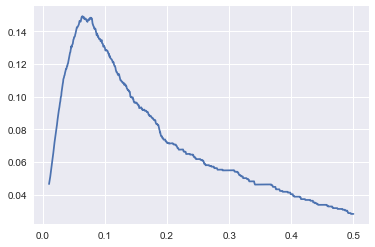

In [78]:
print('Validaion')
val_best_threshold = f1_best_threshold(y_val, val_preds)

#f1 score: 0.143733567046
#best threshold: 0.0673873873874
#TF pred mean: 0.0149941359567

In [79]:
bst.feature_importance()

array([251, 448,  13, 243, 171, 728, 107,   5,  16, 125, 368, 234, 327,
       264,  88, 226, 193,  83,  18, 223, 113, 207,  38,   2, 213, 321,
       487,  57,  90,   6,  24, 136,  92,  22,  30, 147, 184,  35, 614,
       398, 157,  52, 433, 265,   8, 154, 271,  74, 118, 191,  23, 138,
       667,   9, 272, 181,  69, 205, 327,  12,  56,  88,   0, 176, 534,
        15, 222,   0, 585,  17, 489, 190, 718,  74, 383, 181, 347, 371,
        17, 186, 171,  13,  40, 193, 265,  24,   1, 340, 883, 280,   0,
       289, 287, 492])

In [80]:
#feature_list = X_val[features].columns.values
feature_list = X_val[features].columns.values
df_fi = pd.DataFrame(bst.feature_importance(), columns=['importance'])
df_fi['feature'] = feature_list
df_fi = df_fi.sort_values('importance', ascending = 0)
df_fi[df_fi.importance >= 10]

,importance,feature
88,883,ISOCountryShortName
5,728,LifeTimeConversionCount
72,718,LifeTimeImpressionCount
52,667,UniqueUserDeviceKey
38,614,CampaignId
68,585,CampaignIdValueCount
64,534,UniqueUserDeviceKeyValueCount
93,492,DeviceTimezone
70,489,OSOOBEDateTimeDay
26,487,ProcessorClockSpeed


In [25]:
zeroImportance = df_fi[df_fi.importance == 0]['feature'].values
print(len(zeroImportance))

1


In [29]:
bst = lgb.Booster(model_file="model.txt") 

In [91]:
bst

In [81]:
with Timer('# predict test data'):
    preds = bst.predict(test[features], num_iteration=bst.best_iteration)

# predict test data...
2017-04-07 06:10:56.475872
# predict test data: cpu 5.86, time 5.86



In [82]:
#print(bestEpsilon)
print(val_best_threshold)

0.0634634634635


In [83]:
test_id = test.RowNumber.values
submission = pd.DataFrame({'RowNumber': test_id})
submission['HasClicked'] = preds > val_best_threshold
print("Click mean:", submission.HasClicked.mean())
print("Submission file...")
submission.to_csv("W10_Coin_LightGBM_FinalV2_lr0.05_0403.csv", index = False)
submission.head()

Click mean: 0.0259797881525
Submission file...


,RowNumber,HasClicked
0,1,False
1,2,False
2,3,False
3,4,False
4,5,False


In [96]:
print(test_header)
print(test_header2)
print(list(set(test_header) - set(test_header2)))

Index(['RowNumber', 'BubbleShownTime', 'CampaignId', 'creativeName',
       'UniqueUserDeviceKey', 'LifeTimeImpressionCount',
       'LifeTimeConversionCount', 'RecentMonthConversionCount',
       'IsVirtualDevice', 'ISOCountryShortName',
       ...
       'Time_Social', 'Days_Social', 'Time_StudentAndLearning',
       'Days_StudentAndLearning', 'Time_ModernApps', 'Days_ModernApps',
       'Time_Games_Core', 'Days_Games_Core', 'Time_Games_Casual',
       'Days_Games_Casual'],
      dtype='object', length=1084)
Index(['RowNumber', 'BubbleShownTime', 'CampaignId', 'creativeName',
       'UniqueUserDeviceKey', 'LifeTimeImpressionCount',
       'LifeTimeConversionCount', 'RecentMonthConversionCount',
       'IsVirtualDevice', 'ISOCountryShortName',
       ...
       'Time_Social', 'Days_Social', 'Time_StudentAndLearning',
       'Days_StudentAndLearning', 'Time_ModernApps', 'Days_ModernApps',
       'Time_Games_Core', 'Days_Games_Core', 'Time_Games_Casual',
       'Days_Games_Casual'],
   

In [18]:
bst.best_iteration

457

In [97]:
# Read tsv file
test2 = pd.read_csv('../input/CoinMlCompetitionSoftlandingEvaluateNoLabel.tsv', sep='\t', header = None)

# Add header because test does not have header
with open ('test_header', 'rb') as fp:
    test_header2 = pickle.load(fp)

test2.columns = test_header2

# Get feature list
with open ('feature_list', 'rb') as fp:
    features2 = pickle.load(fp)

# Reduce test size by leaving train features only
test2 = test2[list(set(features2) - set(['HasClicked']))]

# Feature engineering - should not delete odd date rows
#test = feature_engineering(test, isDeleteOddDateRows=False)
test2 = feature_engineering(test2)

print(test2.shape)

C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


shape: (374137, 71)
Add datetime features...
BubbleShownTime
FirstUpdatedDate
OSOOBEDateTime
shape: (374137, 83)
Missing value count...
Gamer segment parsing...
Convert categorical columns to numeric...
AppCategoryNMinus7
DisplayLanguage
IsAlwaysOnAlwaysConnectedCapable
AppCategoryNMinus2
creativeName
AppCategoryNMinus5
AppCategoryNMinus1
AppCategoryNMinus6
AppCategoryNMinus4
BubbleShownTime
GamerSegment
ISOCountryShortName
AppCategoryNMinus8
IsDomainJoined
GamerPCClassification
DeviceTimezone
DefaultInternetBrowser
CampaignId
AppCategoryNMinus3
GamerSegment1
creativeNameCotainsSL
creativeNameCotainsTS
creativeNameCotainsWeek7
creativeNameCotainsWeek 7
creativeNameCotainsMeet
creativeNameCotainsSkype
creativeNameCotainsBattery
creativeNameCotainsSwitch
creativeNameCotainsPerformance
creativeNameCotainsSecurity
creativeNameCotainsSurge
Replace missing values with -1
Value count...
UniqueUserDeviceKey
CampaignId
(374137, 100)


In [118]:
df_header = pd.DataFrame(test_header)
df_header.to_csv('test_header.csv', index = False)

#df_header = pd.read_csv('test_header.csv')
#header = df_header['0'].values

In [106]:
df_features = pd.DataFrame(features)
df_features.to_csv('final_features.csv', index = False)

In [108]:
df_feats = pd.read_csv('final_features.csv')
features_final2 = df_feats['0'].values

In [111]:
features_final2 = df_feats['0'].values

In [98]:
# Read final features
with open ('final_feature_list', 'rb') as fp:
    features_final2 = pickle.load(fp)

In [102]:
print(features)
print(features_final2)
# Read tsv file
test2 = pd.read_csv('../input/CoinMlCompetitionSoftlandingEvaluateNoLabel.tsv', sep='\t', header = None)
print(list(set(features)-set(features_final2)))

['AppCategoryNMinus7', 'Time_Search', 'Time_Malware', 'IsPenCapable', 'InternalPrimaryDisplayResolutionVertical', 'Time_ModernApps', 'TotalDays', 'Time_msascui_exe', 'OSOOBEDateTimeHour', 'Time_Communications', 'CntNs', 'BubbleShownTimeMonth', 'ProcessorClockSpeed', 'creativeNameCotainsMeet', 'FirstUpdatedDateHour', 'InternalPrimaryDisplayLogicalDPIY', 'DisplayLanguage', 'AppCatCntNs', 'Time_Accessibility', 'IsAlwaysOnAlwaysConnectedCapable', 'Time_Readers', 'AppCategoryNMinus2', 'CampaignIdValueCount', 'creativeNameCotainsSurge', 'HasFrontFacingCamera', 'IsCommercial', 'Time_Games', 'creativeNameCotainsWeek7', 'creativeName', 'BubbleShownTimeDay', 'AppCategoryNMinus5', 'creativeNameCotainsSwitch', 'Time_Browser', 'Time_Social', 'TotalEngagementTimeInSec', 'AppCategoryNMinus1', 'AppCategoryNMinus6', 'BubbleShownTimeYear', 'BubbleShownTimeHour', 'AppCategoryNMinus4', 'FirstUpdatedDateYear', 'FirstUpdatedDateMonth', 'Time_Games_Core', 'OSOOBEDateTimeYear', 'Time_Media', 'creativeNameCota

In [127]:
initial_features

array(['AppCategoryNMinus7', 'IsPenCapable', 'GamerSegment',
       'InternalPrimaryDisplayResolutionHorizontal',
       'InternalPrimaryDisplayResolutionVertical', 'Time_Search',
       'Time_Malware', 'NumberofInternalDisplays',
       'InternalBatteryNumberOfCharges', 'Time_Games_Casual',
       'Time_ModernApps', 'TotalDays', 'FrontFacingCameraResolution',
       'LifeTimeImpressionCount', 'IsTouchEnabled', 'ProcessorCores',
       'OSOOBEDateTime', 'InternalPrimaryDisplayLogicalDPIX',
       'IsEducation', 'ProcessorPhysicalCores', 'Time_msascui_exe',
       'Time_PersonalProductivity', 'Time_Communications',
       'ISOCountryShortName', 'ProcessorClockSpeed',
       'NumberofExternalDisplays',
       'InternalPrimaryDiagonalDisplaySizeInInches', 'AppCategoryNMinus8',
       'InternalPrimaryDisplayLogicalDPIY', 'DisplayLanguage',
       'Time_lockapphost_exe', 'Time_Accessibility',
       'IsAlwaysOnAlwaysConnectedCapable', 'Time_StudentAndLearning',
       'IsDomainJoined', 'Tim

In [34]:
# Read tsv file
test2 = pd.read_csv('CoinMlCompetitionSoftlandingEvaluateNoLabel.tsv', sep='\t', header = None)

# Add header because test does not header
df_header = pd.read_csv('test_header.csv')
test_header2 = df_header['0'].values

test2.columns = test_header2

# Reduce test size by leaving train features only
df_initial_features = pd.read_csv('initial_features.csv')
initial_features2 = df_initial_features['0'].values

test2 = test2[list(set(initial_features2) - set(['HasClicked']))]

# Feature engineering - should not delete odd date rows
#test = feature_engineering(test, isDeleteOddDateRows=False)
test2 = feature_engineering(test2)

#random.seed(2007)
bst2 = lgb.Booster(model_file="model.txt") 

# Predict test
df_final_features = pd.read_csv('final_features.csv')
final_features2 = df_final_features['0'].values

preds = bst2.predict(test2[final_features2], num_iteration=457)

# Best threshold from train
#val_best_threshold = 0.072
val_best_threshold = 0.075

# Create submissin file
test_id = test2.RowNumber.values
submission = pd.DataFrame({'RowNumber': test_id})
submission['HasClicked'] = preds > val_best_threshold
print("Click mean:", submission.HasClicked.mean())
print("Submission file...")
submission.to_csv("W10_Coin_test_prediction_0403.csv", index = False)
submission.head()

C:\Users\ryutek\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


shape: (374137, 71)
Add datetime features...
BubbleShownTime
FirstUpdatedDate
OSOOBEDateTime
shape: (374137, 83)
Missing value count...
Gamer segment parsing...
Convert categorical columns to numeric...
CampaignId
BubbleShownTime
AppCategoryNMinus2
ISOCountryShortName
IsAlwaysOnAlwaysConnectedCapable
AppCategoryNMinus4
AppCategoryNMinus5
GamerPCClassification
GamerSegment
IsDomainJoined
AppCategoryNMinus6
DeviceTimezone
DisplayLanguage
AppCategoryNMinus3
AppCategoryNMinus7
DefaultInternetBrowser
AppCategoryNMinus8
AppCategoryNMinus1
creativeName
GamerSegment1
creativeNameCotainsSL
creativeNameCotainsTS
creativeNameCotainsWeek7
creativeNameCotainsWeek 7
creativeNameCotainsMeet
creativeNameCotainsSkype
creativeNameCotainsBattery
creativeNameCotainsSwitch
creativeNameCotainsPerformance
creativeNameCotainsSecurity
creativeNameCotainsSurge
Replace missing values with -1
Value count...
UniqueUserDeviceKey
CampaignId


LightGBMError: b'Wrong size of feature_names'

In [120]:
# Read trained model
#random.seed(2007)
bst3 = lgb.Booster(model_file="model.txt") 

# Predict test
preds = bst3.predict(test2[features], num_iteration=bst.best_iteration)

# Best threshold from train
#val_best_threshold = 0.072
val_best_threshold = 0.075

# Create submissin file
test_id = test2.RowNumber.values
submission = pd.DataFrame({'RowNumber': test_id})
submission['HasClicked'] = preds > val_best_threshold
print("Click mean:", submission.HasClicked.mean())
print("Submission file...")
submission.to_csv("W10_Coin_test_prediction_0403.csv", index = False)
print(submission.head())
print(preds)

KeyError: "['HasClicked'] not in index"

In [ ]:
# load model with pickle to predict
with open('model.pkl', 'rb') as fin:
    pkl_bst = pickle.load(fin)
    
# Predict test
preds = pkl_bst.predict(test[features], num_iteration=bst.best_iteration)

# Best threshold from train
#val_best_threshold = 0.072
val_best_threshold = 0.075

# Create submissin file
test_id = test.RowNumber.values
submission = pd.DataFrame({'RowNumber': test_id})
submission['HasClicked'] = preds > val_best_threshold
print("Click mean:", submission.HasClicked.mean())
print("Submission file...")
submission.to_csv("W10_Coin_test_prediction_0403.csv", index = False)
submission.head()

In [48]:
preds

array([ 0.12908386,  0.0765627 ,  0.10802078, ...,  0.10601138,
        0.10591388,  0.09853806], dtype=float32)

In [23]:
features

['IsPenCapable',
 'Time_Games_Core',
 'creativeNameCotainsPerformance',
 'AppCategoryNMinus8',
 'Time_PersonalProductivity',
 'BubbleShownTimeHour',
 'Time_StudentAndLearning',
 'BubbleShownTimeYear',
 'Time_Media',
 'AppCategoryNMinus7',
 'IsVirtualDevice',
 'CampaignIdValueCount',
 'CntNs',
 'AppCatCntNs',
 'TotalDays',
 'LifeTimeConversionCount',
 'InternalPrimaryDiagonalDisplaySizeInInches',
 'Time_Communications',
 'Time_Search',
 'creativeNameCotainsSwitch',
 'NumberofExternalDisplays',
 'Time_microsoft_windows_cortana',
 'creativeNameCotainsWeek7',
 'AppCategoryNMinus6',
 'UniqueUserDeviceKeyValueCount',
 'IsAlwaysOnAlwaysConnectedCapable',
 'TotalPhysicalRAM',
 'GamerSegment',
 'UniqueUserDeviceKey',
 'PrimaryDiskTotalCapacity',
 'Time_chrome_exe',
 'Time_Accessibility',
 'creativeNameCotainsSecurity',
 'Time_msascui_exe',
 'Time_Social',
 'AppCategoryNMinus5',
 'Time_Content',
 'FirstUpdatedDateDay',
 'IsCommercial',
 'AppCategoryNMinus3',
 'BubbleShownTimeDay',
 'OSOOBEDateTi

In [38]:
txt = 'abc f'
hash(txt)

-6139562895366302631

In [39]:
hash(txt)

-6139562895366302631

In [40]:
random.seed(2000)
hash(txt)

-6139562895366302631

In [65]:
import hashlib
txt = b'abc f'
def sha256_hash_as_int(s):
    return int(hashlib.sha256(str(s).encode('utf-8')).hexdigest(), 16) % (10 ** 16)
sha256_hash_as_int(txt)

9655835737071027

In [53]:
import hashlib
txt = b'abc f'
def sha256_hash_as_int(s):
    return int(hashlib.sha256(s).digest(), 4)
sha256_hash_as_int(txt)

ValueError: invalid literal for int() with base 4: b'\xa9`\xb4\xf3\xeb\xc1*\x08\xe4FrS\n\xd9\x80=\xa8y\x17\x1eb-\x06\xd8\x1a\xd2\xab\xe8M)\xee\x83'

In [62]:
int(hashlib.sha1(txt).hexdigest(), 16) % (10 ** 16)

2651114539135181

In [63]:
import hashlib
txt = b'abc f'
int(hashlib.sha1(txt).hexdigest(), 16) % (10 ** 16)

2651114539135181